In [1]:
from agents import agent_loss, CAPM_Agent, MVP_Agent, Uniform_Agent
from trading_env.environment import TradingEnv

import dill
import matplotlib.pyplot as plt

In [2]:
with open('test_data.dill','rb') as dill_file:
    test_data = dill.load(dill_file)
test_dates = test_data['dates']
test_data = test_data['data']

n_stocks = test_data.shape[0]

In [3]:
with open('dpm_agent.dill','rb') as dill_file:
    dpm_agent = dill.load(dill_file)

capm_agent = CAPM_Agent(n_stocks)
mvp_agent = MVP_Agent(n_stocks)
uniform_agent = Uniform_Agent(n_stocks)

In [4]:
env = TradingEnv(test_data)

dpm_loss = agent_loss(env,dpm_agent,n_stocks)
dpm_val_hist = env.portfolio_value_hist

uniform_loss = agent_loss(env,uniform_agent,n_stocks)
uniform_val_hist = env.portfolio_value_hist

mvp_loss = agent_loss(env,mvp_agent,n_stocks)
mvp_val_hist = env.portfolio_value_hist

capm_loss = agent_loss(env,capm_agent,n_stocks)
capm_val_hist = env.portfolio_value_hist

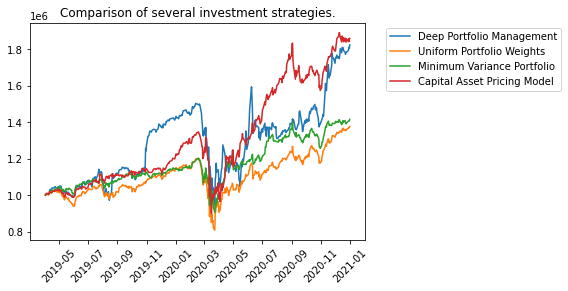

In [5]:
plt.plot(test_dates[63:],dpm_val_hist,label='Deep Portfolio Management')
plt.plot(test_dates[63:],uniform_val_hist,label='Uniform Portfolio Weights')
plt.plot(test_dates[63:],mvp_val_hist,label='Minimum Variance Portfolio')
plt.plot(test_dates[63:],capm_val_hist,label='Capital Asset Pricing Model')
plt.xticks(rotation=45)
plt.legend(loc='upper right',bbox_to_anchor=(1.6, 1) )
plt.title('Comparison of several investment strategies.')
plt.show()